Iteration limit exceeded    (Exit mode 9)
            Current function value: 2.5466138966016514
            Iterations: 101
            Function evaluations: 749
            Gradient evaluations: 100
Model: CompoundModel0
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian1D(amplitude=2.5408601796930876e-44, mean=1.4768890911600128, stddev=0.71348759626021)>

    [1]: <Linear1D(slope=2.2070949678495877e-45, intercept=-1.684127439035524e-44)>
Parameters:
     amplitude_0      mean_0       stddev_0      slope_1       intercept_1  
    ------------- ------------- ------------- -------------- ---------------
    1.26779188516 0.73844454558 0.35674379813 0.220251166309 -0.840315070407
Model: CompoundModel0
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian1D(amplitude=2.5408601796930876e-44, mean=1.4768890911600128, stddev=0.71348759626021)>

    [1]: <Linear1D(slope=2.2070949678495877e-4

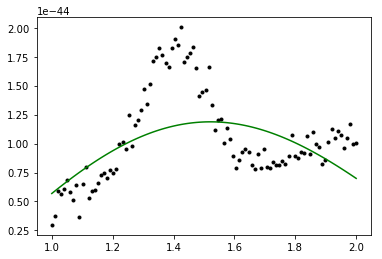

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from astropy import units as u
from astropy.modeling import models, fitting

# Parametrize the scale of the data to play around with more easily
SCALE = 1e-44

# Set up simulated data. 
w1 = np.linspace(1, 2, 100)
f1 = (1.2 * SCALE * np.exp(-0.5 * (w1 - 1.4)**2 / 0.1**2) +
      SCALE * (0.01 + 0.5 * w1) + 
      SCALE / 10 * np.random.normal(0, 1, len(w1)))
# f1 = (1.2 * SCALE * np.exp(-0.5 * (w1 - 1.4)**2 / 0.1**2) +
#       SCALE / 10 * np.random.normal(0, 1, len(w1)))

# Set up initial model
g1 = models.Gaussian1D() + models.Linear1D()
# g1 = models.Gaussian1D() 

# Set up fitter
slsqp_fitter = fitting.SLSQPLSQFitter()

# Define custom units for x and y
ux1 = u.def_unit('ux1')
uy1 = u.def_unit('uy1')
w1 = w1 * ux1
f1 = f1 * uy1

# Determine maximum values in each direction
wmax = np.max(np.abs(w1.value))
fmax = np.max(np.abs(f1.value))

# Define new units so that in this system, the data is always in the range
# [-1:1] in both directions and convert data to that frame.
ux2 = u.Unit(wmax * w1.unit)
uy2 = u.Unit(fmax * f1.unit)
w2 = w1.to(ux2)
f2 = f1.to(uy2)

# Strip away the units for the fitting
w3 = w2.value
f3 = f2.value

# Run the fitting
g3_new = slsqp_fitter(g1, w3, f3)

# Add units to the parameters for the data that was fit, and then transform
# the parameters to the original units of the data
g2_new = g3_new.with_units_from_data(x=w2, y=f2)
g1_new = g2_new.without_units_for_data(x=w1, y=f1)

print(g3_new)
print(g2_new)
print(g1_new)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(w1.value, f1.value, 'k.')
ax.plot(w1.value, g1_new(w1.value), 'g-')
ax.set_autoscale_on(False)
ax.plot(w1.value, g1(w1.value), 'r-')
fig.savefig('fit.png')